In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Processada70.zip to Processada70.zip


In [ ]:
import zipfile
import io 
data =zipfile.ZipFile(io.BytesIO(uploaded['Processada70.zip']),'r')
data.extractall()


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
from PIL import Image
from os import listdir
from os.path import isdir

In [ ]:

CATEGORIES = ["germinou", "naogerminou"]
BASES = [ "/content/Processada70/Train", 
          "/content/Processada70/Validacao",
          "/content/Processada70/Test"]

In [ ]:
training_data  =  [] 
validacao_data  =  [] 
test_data  =  [] 



def create_training_data():
    for base in BASES:
        
        for category in CATEGORIES:  # germinadas e não germinadas
            # cria caminho para as sementes
            path = os.path.join(base,category)  
            # obtém a classificação (0 ou 1). 0 = Germinou 1 = Nãogerminou
            class_num = CATEGORIES.index(category)  
             # itere sobre cada imagem por 
            for img in tqdm(os.listdir(path)):  
                try:
                    image = Image.open(os.path.join(path,img))
                    image = image.resize((100,100))
                    image = np.asarray(image)
                    if BASES.index(base) == 0:
                        training_data.append([image, class_num]) 
                    elif BASES.index(base) == 1:
                        validacao_data.append([image, class_num]) 
                    else:
                        test_data.append([image, class_num]) 

                except Exception as e: 
                    pass
           
        
create_training_data()

print(len(training_data))
print(len(validacao_data))
print(len(test_data))

100%|██████████| 490/490 [00:01<00:00, 332.90it/s]

6974
1766
980


In [ ]:

import random

random.shuffle(training_data)
random.shuffle(validacao_data)
random.shuffle(test_data)

In [ ]:
for sample in training_data[:10]:
    print(sample[1])



0
0
1
1
1
1
1
1
0
0


In [ ]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)


X = np.array(X)/255.0
y= np.array(y)

In [ ]:
X_val = []
y_val = []

for features,label in validacao_data:
    X_val.append(features)
    y_val.append(label)


X_val = np.array(X_val)/255.0
y_val= np.array(y_val)

In [ ]:
X_test = []
y_test = []

for features,label in test_data:
    X_test.append(features)
    y_test.append(label)


X_test = np.array(X_test)/255.0
y_test= np.array(y_test)

## Checando quantidade de imagens do dataset



Quantidade de imagens de treino: 6974
Quantidade de imagens de validação: 1766
Quantidade de imagens de test: 980


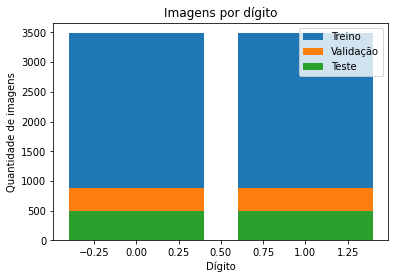

In [ ]:
print('Quantidade de imagens de treino:', y.shape[0])
print('Quantidade de imagens de validação:', y_val.shape[0])
print('Quantidade de imagens de test:', y_test.shape[0])


import collections
counterTrain=collections.Counter(y)
counterVal=collections.Counter(y_val)
counterTest=collections.Counter(y_test)

from matplotlib import pyplot

fig, ax = pyplot.subplots()
rects1 = ax.bar(counterTrain.keys(), counterTrain.values(), label='Treino')
rects2 = ax.bar(counterVal.keys(), counterVal.values(), label='Validação')
rects3 = ax.bar(counterTest.keys(), counterTest.values(), label='Teste')

ax.set_title('Imagens por dígito')
ax.set_ylabel('Quantidade de imagens')
ax.set_xlabel('Dígito')
ax.legend()
pyplot.show()

In [ ]:

batch_size   = 64
input_shape  = (100, 100, 3)
random_state = 42
alpha        = 1e-5
epoch        = 100

# TRANSFER LEARNING


In [ ]:
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3
conv_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
conv_base.summary()


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [ ]:
conv_base.trainable = False

len(conv_base.layers)

22

In [ ]:
for layer in conv_base.layers[:22]:
  layer.trainable = False

In [ ]:
conv_base.summary()


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

#  Retreinando parte da VGG19


In [ ]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'conv5_bock1_preact_bn':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


conv_base.summary()


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D

# CONSTRUINDO O MODELO COM A ARQUITETURA COMO BASE


In [ ]:

model = Sequential()
model.add(conv_base)
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors


model.add(Dense(512, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# MODELO CONSTRUÍDO DO ZERO

In [ ]:
'''model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16,(3,3), input_shape= input_shape),
        tf.keras.layers.MaxPooling2D(2,2),
    
        tf.keras.layers.Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.MaxPooling2D(2,2),
    
        tf.keras.layers.Conv2D(64,(3,3),activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.MaxPooling2D(2,2),
    
     
    
      
    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(512, activation='relu',kernel_initializer='he_normal'),
    
        tf.keras.layers.Dense(2,activation='softmax')
        
])
'''

model = Sequential()

model.add(Conv2D(64, (5,5), input_shape= input_shape))
model.add(Activation('relu',))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())


model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())





model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())





model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())




model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())




model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dense(128, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(128, kernel_initializer='he_normal'))
model.add(Activation('relu'))
model.add(Dropout(0.5))






model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 64)        4864      
_________________________________________________________________
activation_2 (Activation)    (None, 96, 96, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 96, 96, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
activation_3 (Activation)    (None, 46, 46, 64)       

## DEFININDO OS CALLBACKS

In [ ]:
from tensorflow.keras.callbacks import  ReduceLROnPlateau

In [ ]:
#lr_reduce =tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.001, patience=3, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,monitor='val_accuracy',min_delta=0.001,verbose=1)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy',mode='auto', factor=0.9, min_delta=1e-5, patience=5, verbose=1)

# TREINAMENTO

In [ ]:

history=model.fit(X, y, batch_size=batch_size, steps_per_epoch=len(X)//batch_size, epochs=30,validation_steps=len(X_val) // batch_size, callbacks=[lr_reduce],validation_data=(X_val,y_val),verbose=2)

Epoch 1/30
108/108 - 22s - loss: 0.4612 - accuracy: 0.7823 - val_loss: 0.8686 - val_accuracy: 0.5046 - lr: 0.0010
Epoch 2/30
108/108 - 22s - loss: 0.3692 - accuracy: 0.8272 - val_loss: 0.6758 - val_accuracy: 0.5052 - lr: 0.0010
Epoch 3/30
108/108 - 22s - loss: 0.3277 - accuracy: 0.8493 - val_loss: 0.5488 - val_accuracy: 0.6684 - lr: 0.0010
Epoch 4/30
108/108 - 22s - loss: 0.3059 - accuracy: 0.8585 - val_loss: 0.4341 - val_accuracy: 0.8015 - lr: 0.0010
Epoch 5/30
108/108 - 22s - loss: 0.2980 - accuracy: 0.8632 - val_loss: 0.3377 - val_accuracy: 0.8652 - lr: 0.0010
Epoch 6/30
108/108 - 22s - loss: 0.2708 - accuracy: 0.8838 - val_loss: 0.2966 - val_accuracy: 0.8715 - lr: 0.0010
Epoch 7/30
108/108 - 22s - loss: 0.2547 - accuracy: 0.8878 - val_loss: 0.2819 - val_accuracy: 0.8675 - lr: 0.0010
Epoch 8/30
108/108 - 22s - loss: 0.2408 - accuracy: 0.8926 - val_loss: 0.2876 - val_accuracy: 0.8727 - lr: 0.0010
Epoch 9/30
108/108 - 22s - loss: 0.2221 - accuracy: 0.9055 - val_loss: 0.2632 - val_accu

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
acc=history.history['accuracy']
acc.pop(0)
val_acc=history.history['val_accuracy']
val_acc.pop(0)
loss=history.history['loss']
loss.pop(0)
val_loss=history.history['val_loss']
val_loss.pop(0)



0.8641465306282043

In [ ]:
history.history[]

KeyError: ignored

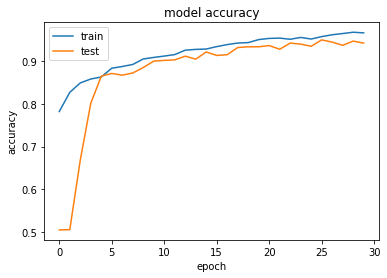

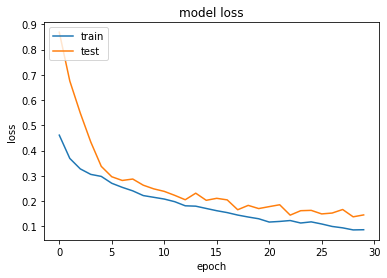

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# TESTANDO O MODELO

In [ ]:
test_loss, test_accuracy=model.evaluate(X_test,y_test)


31/31 [==============================] - 3s 93ms/step - loss: 0.1396 - accuracy: 0.9459


In [ ]:
classe = model.predict(X_test)


In [ ]:
print(classe[50])

[0.05074522 0.94925475]


In [ ]:
score = model.evaluate(X_test, y_test)

print( '\nPerda:{:.3f}\nAcurácia:{}'.format( score[0], score[1] ) )


31/31 [==============================] - 3s 90ms/step - loss: 0.1310 - accuracy: 0.9500

Perda:0.131
Acurácia:0.949999988079071


# MATRIZ DE CONFUSÃO

In [ ]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1) 


Acurácia: 0.9459
Sensitividade: 0.9388
Especificidade: 0.9531


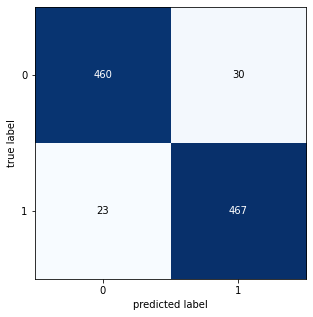

In [ ]:
cm = confusion_matrix(y_test, pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print("Acurácia: {:.4f}".format(acc))
print("Sensitividade: {:.4f}".format(sensitivity))
print("Especificidade: {:.4f}".format(specificity))

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(5, 5))
plt.show()